## **Image Classification of Animals Using CNNs and PCA**
#### `Dawit Hailu`, `Geraldine Marten-Ellis`, `Jan McConnell`, `Aaron J. Smith`
**DS510 Team Project** `Summer 2025`

### **Introduction**


> This project looks at how well Convolutional Neural Networks (CNNs) can classify images of animals and examines whether applying Principal Component Analysis (PCA) improves the results, using a small selection from the High-Resolution Cat-Dog-Bird Image Dataset, with 150 grayscale images in total, divided evenly between cats, dogs, and birds. Our goal is to compare classification accuracy, training time, and loss between models trained on raw images and those preprocessed with PCA. The project highlights how dimensionality reduction can influence both efficiency and generalization in small-scale image classification tasks. Performance metrics and visualizations, including confusion matrices and loss curves will support findings.

*Setup and Imports*

In [1]:
# ! pip install torch torchvision matplotlib scikit-learn pandas numpy scikeras tensorflow opencv-python-headless

In [2]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.decomposition import PCA
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split

## 1 **CNN Solution**

#### 1.1 **Load and Preprocess Dataset**

This class handles reading downloaded CSV datasets, `normalizing` and `reshaping` the image data, `splitting` into training, validation, and test sets, and preparing PyTorch `DataLoader` objects for use in model training class workflows. It also manages label remapping and provides access to data splits, tensors, and class mappings.

In [3]:
class DataModule:
    def __init__(self, data_dir="./dataset", dataset_dir = "mnist-animals-dataset", test_size=0.2, random_state=42):
        self.data_dir = data_dir
        self.dataset_dir = dataset_dir
        self.test_size = test_size
        self.random_state = random_state
        
        self.class_map = None
        # training data
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        

        self._preprocess()
    def _preprocess(self):
        # Resize images to 28x28 if not already
        if not os.path.exists(self.data_dir):
            raise FileNotFoundError(f"Data directory {self.data_dir} does not exist. Please check the path.")
        
        # check if preprocessed data already exists
        csv_target = f"{self.dataset_dir}/mnist-animals.csv"
        data = []
        
        if not os.path.exists(csv_target):
            # create dataset directory if it does not exist
            if not os.path.exists(self.dataset_dir):
                os.makedirs(self.dataset_dir)
            # This loop assumes the images are categorized in subdirectories
                # e.g., data_dir/cat, data_dir/dog, data_dir/bird
            for subdir in os.listdir(self.data_dir):
                subdir_path = os.path.join(self.data_dir, subdir)
                for file in os.listdir(subdir_path):
                    if file.endswith('.png') or file.endswith('.jpg'):
                        file_path = os.path.join(subdir_path, file)
                        
                        # Here we resize the image to 28x28 and append it to csv
                        im = cv2.imread(file_path)
                        if im.shape[0] != 28 and im.shape[1] != 28:
                            gray_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
                            resized_image = cv2.resize(gray_im, (28,28)).flatten()
                            # add image class to the resized image
                            class_name = [subdir]
                            row = class_name + resized_image.tolist()
                            data = data + [row]
            df = pd.DataFrame(data, columns=(['class'] + [f'pixel_{i}' for i in range(28 * 28)]))
            df.to_csv(csv_target, index=False) 
                        
            print(f"Preprocessing complete. CSV file saved to {csv_target}")
            
        else:
            print(f"CSV files already exist in {self.data_dir}/{self.data_dir}. Skipping preprocessing step.")                  
        
            # Now we can read the csv file and split it into train and test sets
            df = pd.read_csv(csv_target)
        self._set_data(df)
        

    def _set_data(self, data):
        self.class_map = {i: label for i, label in enumerate(data['class'].unique())}
        X= data.drop(columns=['class']).values
        y = data['class'].apply(lambda x: list(self.class_map.keys())[list(self.class_map.values()).index(x)]).values
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
        
    def get_class_map(self):
        return self.class_map
    
    def get_train_data(self):
        return self.x_train, self.y_train, self.x_test, self.y_test

### 1.2 Sample data

In [4]:

dataset = DataModule(data_dir="./dataset", dataset_dir="mnist-animals", test_size=0.2, random_state=42)

x_train_data, y_train_data, x_test_data, y_test_data = dataset.get_train_data()
# Reshape and normalize data
print(x_train_data.shape, x_test_data.shape)
X_train_norm = x_train_data.astype("float32") / 255.0
X_test_norm = x_test_data.astype("float32") / 255.0
X_train = X_train_norm.reshape(-1, 28, 28, 1)
X_test = X_test_norm.reshape(-1, 28, 28, 1)
print(X_train.shape, X_test.shape)

print(f"Train data shape: {dataset.x_train.shape}, Train labels shape: {dataset.y_train.shape}")
print(f"Test data shape: {dataset.x_test.shape}, Test labels shape: {dataset.y_test.shape}")
print(f"Class map: {dataset.class_map}")


CSV files already exist in ./dataset/./dataset. Skipping preprocessing step.
(120, 784) (30, 784)
(120, 28, 28, 1) (30, 28, 28, 1)
Train data shape: (120, 784), Train labels shape: (120,)
Test data shape: (30, 784), Test labels shape: (30,)
Class map: {0: 'bird', 1: 'cat', 2: 'dog'}


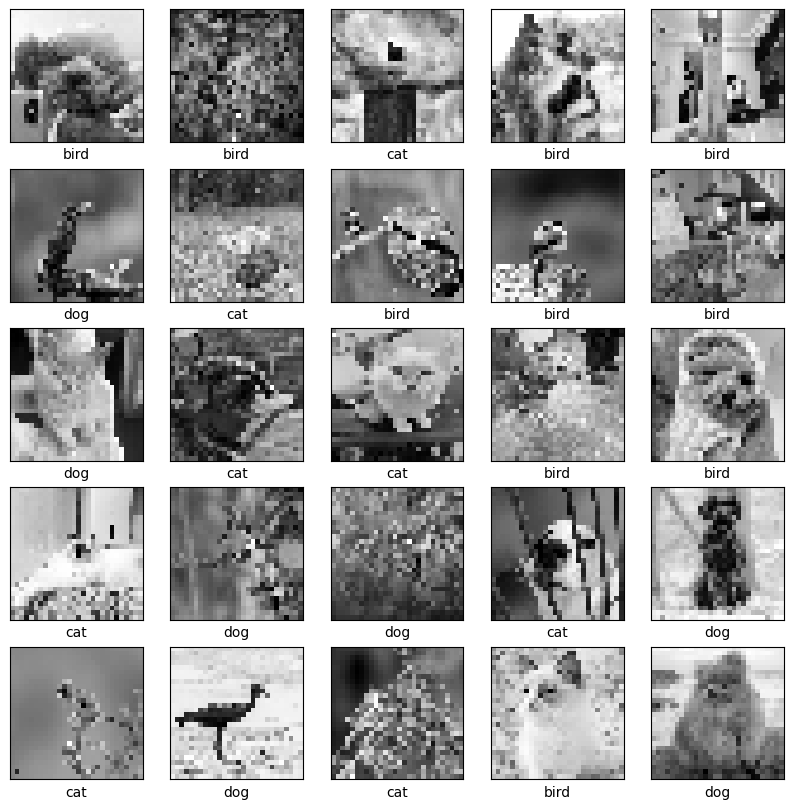

In [5]:
# visualize sample image
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i+50], cmap='gray')
    plt.xlabel(dataset.class_map[y_train_data[i]])

### 1.2 **Train and Predict**

In [6]:

def make_cnn_model(input_shape=(28, 28, 1)):
    model = keras.Sequential([
        layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

clf = KerasClassifier(model=make_cnn_model, epochs=45, batch_size=16, verbose=6, random_state=42)
clf.fit(X_train, y_train_data)

score = clf.score(X_test, y_test_data)
print(f"Test accuracy: {score:.3f}")

Epoch 1/45


C:\Users\davuc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 2/45
Epoch 3/45
Epoch 4/45
Epoch 5/45
Epoch 6/45
Epoch 7/45
Epoch 8/45
Epoch 9/45
Epoch 10/45
Epoch 11/45
Epoch 12/45
Epoch 13/45
Epoch 14/45
Epoch 15/45
Epoch 16/45
Epoch 17/45
Epoch 18/45
Epoch 19/45
Epoch 20/45
Epoch 21/45
Epoch 22/45
Epoch 23/45
Epoch 24/45
Epoch 25/45
Epoch 26/45
Epoch 27/45
Epoch 28/45
Epoch 29/45
Epoch 30/45
Epoch 31/45
Epoch 32/45
Epoch 33/45
Epoch 34/45
Epoch 35/45
Epoch 36/45
Epoch 37/45
Epoch 38/45
Epoch 39/45
Epoch 40/45
Epoch 41/45
Epoch 42/45
Epoch 43/45
Epoch 44/45
Epoch 45/45
Test accuracy: 0.567


## 2. **PCA Implementation**

### 2.1 **PCA Before normalization**

In [7]:

pca = PCA(n_components=100)  # Retain 65% of variance
x_train_pca = pca.fit_transform(x_train_data)
x_test_pca = pca.transform(x_test_data)

print(f"Original shape: {x_train_data.shape}, PCA shape: {x_train_pca.shape}")

# Reshape and normalize PCA data
X_train_pca = x_train_pca.reshape(-1, 10, 10, 1).astype("float32") / 255.0
X_test_pca = x_test_pca.reshape(-1, 10, 10, 1).astype("float32") / 255.0

clf_pca = KerasClassifier(model=make_cnn_model(input_shape=(10, 10, 1)), epochs=40, batch_size=6, verbose=6, random_state=42)
clf_pca.fit(X_train_pca, y_train_data)
score_pca = clf_pca.score(X_test_pca, y_test_data)
print(f"Test accuracy with PCA: {score_pca:.3f}")

Original shape: (120, 784), PCA shape: (120, 100)
Epoch 1/40


C:\Users\davuc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 2/40
Epoch 3/40
Epoch 4/40
Epoch 5/40
Epoch 6/40
Epoch 7/40
Epoch 8/40
Epoch 9/40
Epoch 10/40
Epoch 11/40
Epoch 12/40
Epoch 13/40
Epoch 14/40
Epoch 15/40
Epoch 16/40
Epoch 17/40
Epoch 18/40
Epoch 19/40
Epoch 20/40
Epoch 21/40
Epoch 22/40
Epoch 23/40
Epoch 24/40
Epoch 25/40
Epoch 26/40
Epoch 27/40
Epoch 28/40
Epoch 29/40
Epoch 30/40
Epoch 31/40
Epoch 32/40
Epoch 33/40
Epoch 34/40
Epoch 35/40
Epoch 36/40
Epoch 37/40
Epoch 38/40
Epoch 39/40
Epoch 40/40
Test accuracy with PCA: 0.433
